In [6]:
import sys
# sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

from pylab import *
import pickle
from math import log
from torch.nn import parameter

import torch 
import torch.nn as nn

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from fracturbulence.common import *
from fracturbulence.Calibration import CalibrationProblem
from fracturbulence.DataGenerator import OnePointSpectraDataGenerator

import constants.consts_exp1 as consts_exp1

from time import time

from pathlib import Path

savedir = Path().resolve() / "data" / "results" 

In [7]:
import fracturbulence as ft

In [8]:
config = {
    'type_EddyLifetime' :   'tauNet', #'TwoThird', #'tauNet', # CALIBRATION : 'tauNet',  ### 'const', TwoThird', 'Mann', 'tauNet'
    'type_PowerSpectra' :   'RDT', ### 'RDT', 'zetaNet', 'C3Net', 'Corrector'
    'nlayers'           :   2,
    'activations': [nn.ReLU(), nn.ReLU()],
    'hlayers' : [10, 10], 
    #'hidden_layer_size' :   10,
    # 'nModes'            :   5, ### number of modes in the rational function in tauNet ### deprecated
    'learn_nu'          :   False, ### NOTE: Experiment 1: False, Experiment 2: True
    'plt_tau'           :   True,
    'plot_loss_wolfe'   :   True, 
    'tol'               :   1.e-3, ### not important
    'lr'                :   1,     ### learning rate
    'penalty'           :   1, # CALIBRATION: 1.e-1,
    'regularization'    :   1.e-5,# CALIBRATION: 1.e-1,
    'nepochs'           :   10,
    'curves'            :   [0,1,2,3],
    'data_type'         :   'Kaimal',  # CALIBRATION: 'Custom', ### 'Kaimal', 'SimiuScanlan', 'SimiuYeo', 'iso'
    'spectra_file'      :   'Spectra.dat',
    'Uref'              :   10, # m/s
    'zref'              :   1, #m
    'domain'            :   torch.logspace(-1, 2, 20), #np.logspace(-4, 2, 40), ### NOTE: Experiment 1: np.logspace(-1, 2, 20), Experiment 2: np.logspace(-2, 2, 40)
    'noisy_data'        :   0.,#0*3.e-1, ### level of the data noise  ### NOTE: Experiment 1: zero, Experiment 2: non-zero
    'output_folder'     :   str(savedir), 
    'input_folder'     :   '/Users/gdeskos/work_in_progress/WindGenerator/script/'
}


[ReLU(), ReLU()]
DataValues is on 0
[format_output] -- HERE!

Calibrating MannNet...
torch.Size([80])
Initial loss:  0.09212675637938483

[Calibration.py -- calibrate]-> Epoch 0

loss  =  0.09220794457754289
loss  =  0.8483109086402683
loss  =  0.03859033057377839
loss  =  0.03845048469656223
loss  =  0.037844098080277805
loss  =  0.037808283897364604
loss  =  0.03779372242569506
loss  =  0.037793670322688364
---------------------------------



[Calibration.py -- calibrate]-> Epoch 1



/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


loss  =  0.037793670322688364
---------------------------------



[Calibration.py -- calibrate]-> Epoch 2

loss  =  0.037793670322688364
---------------------------------



[Calibration.py -- calibrate]-> Epoch 3

loss  =  0.037793670322688364
---------------------------------



[Calibration.py -- calibrate]-> Epoch 4

loss  =  0.037793670322688364
---------------------------------



[Calibration.py -- calibrate]-> Epoch 5

loss  =  0.037793670322688364
---------------------------------



[Calibration.py -- calibrate]-> Epoch 6

loss  =  0.037793670322688364
---------------------------------



[Calibration.py -- calibrate]-> Epoch 7

loss  =  0.037793670322688364
---------------------------------



[Calibration.py -- calibrate]-> Epoch 8

loss  =  0.037793670322688364
---------------------------------



[Calibration.py -- calibrate]-> Epoch 9

loss  =  0.037793670322688364
---------------------------------



{Calibration.py -- calibrate} Calibration terminated.

loss = 0.03779

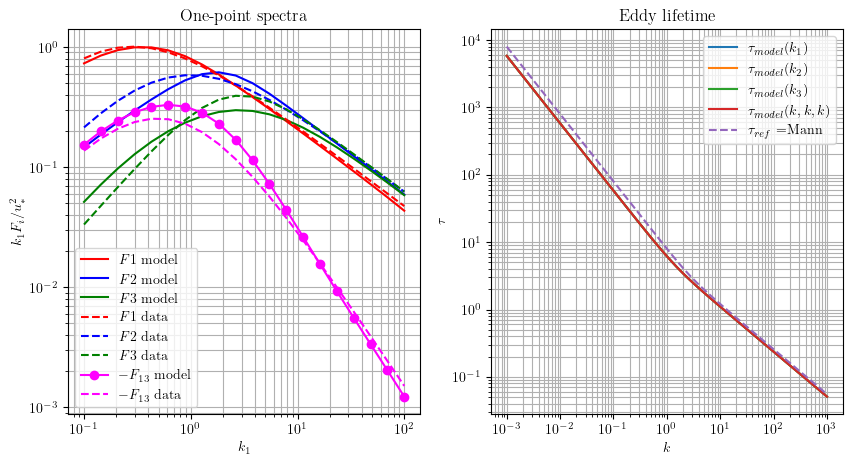

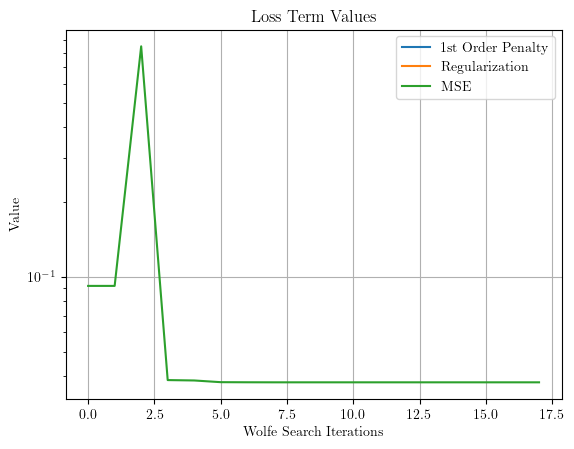

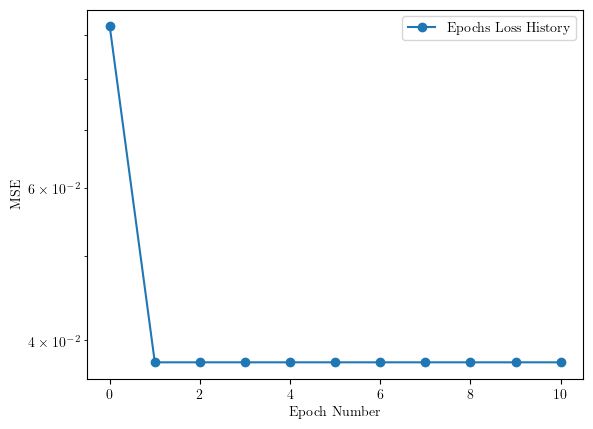

In [9]:
start = time() 

pb = CalibrationProblem(**config)
parameters = pb.parameters
parameters[:3] = [log(consts_exp1.L), log(consts_exp1.Gamma), log(consts_exp1.sigma)] #All of these parameters are positive 
    #so we can train the NN for the log of these parameters. 
pb.parameters = parameters[:len(pb.parameters)]
k1_data_pts = config['domain'] #np.logspace(-1, 2, 20)
DataPoints  = [ (k1, 1) for k1 in k1_data_pts ]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, **config).Data

DataValues = Data[1]

IECtau=MannEddyLifetime(k1_data_pts*consts_exp1.L)
kF = pb.eval(k1_data_pts)

opt_params = pb.calibrate(Data=Data, **config)#, OptimizerClass=torch.optim.RMSprop)

plt.figure()

        #plt.plot( pb.loss_history_total, label="Total Loss History")
plt.plot( pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend() 
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show() 


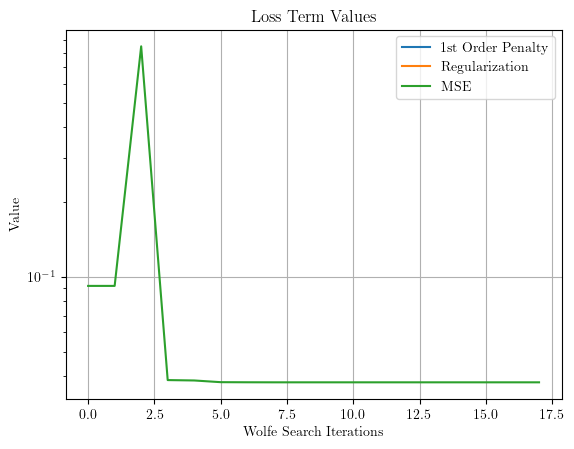

In [10]:
plt.figure()
plt.plot(pb.loss_2ndOpen, label="1st Order Penalty")
plt.plot(pb.loss_reg,  label="Regularization")
plt.plot(pb.loss_history_total, label="MSE")

plt.title("Loss Term Values")

plt.ylabel("Value")
plt.xlabel("Wolfe Search Iterations")
plt.yscale('log')
plt.legend()
plt.grid('true')
plt.show()
